# Generic pipeline for segmentation tests

This notebook demonstrates how a pretrained model can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects.

In [12]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
from rich import print as pp

# --------------------------------------
import numpy as np

# --------------------------------------
import xarray as xr

# --------------------------------------
from streetscapes import conf
from streetscapes import segmentation as sseg

Load a subset file.

In [2]:
amsterdam_side = conf.OUTPUT_DIR / "amsterdam_side.csv"

Go through all the images for that subset and segment them. We are only going to segment 10 images as processing a single image takes a long time (unless a GPU is available).

In [13]:
(ds, filename) = sseg.segment_from_dataset(amsterdam_side, sample=10)

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


Make sure that the dataset can be loaded from the saved file.

In [14]:
ds = xr.open_dataset(filename)

Show an aggregated view of the dataset.

In [15]:
ds

<xarray.Dataset> Size: 68kB
Dimensions:      (category: 65, image: 10, stats: 4, colour: 3)
Coordinates:
  * category     (category) object 520B 'bird' 'ground-animal' ... 'ego-vehicle'
  * image        (image) object 80B '1000939573869762.jpeg' ... '101159991306...
  * stats        (stats) object 32B 'median' 'mode' 'mean' 'sd'
  * colour       (colour) object 24B 'R' 'G' 'B'
Data variables:
    colour_info  (image, category, stats, colour) float64 62kB ...
    segment      (image, category) float64 5kB ...

Show a subset of the dataset for a given image and categories

In [16]:
ds.sel(image="1000939573869762.jpeg", category=["sky", "building"])

<xarray.Dataset> Size: 364B
Dimensions:      (category: 2, stats: 4, colour: 3)
Coordinates:
  * category     (category) object 16B 'sky' 'building'
    image        <U21 84B '1000939573869762.jpeg'
  * stats        (stats) object 32B 'median' 'mode' 'mean' 'sd'
  * colour       (colour) object 24B 'R' 'G' 'B'
Data variables:
    colour_info  (category, stats, colour) float64 192B ...
    segment      (category) float64 16B ...

Pick a random image from the dataset, then visualise the segmentation and show the statistics for the selected categories.

In [42]:
image = np.random.choice(ds.image)
image

'1000939573869762.jpeg'

Compile the path to the actual image to pass to the visualisation function.

In [43]:
image_path = conf.OUTPUT_DIR / f"images/{image}"

### Visualise the the segmentation results

Select a few categories.

In [44]:
categories = ["sky", "building", "road", "vegetation", "water", "sidewalk"]

Visualise the segmentation for the selected categories.

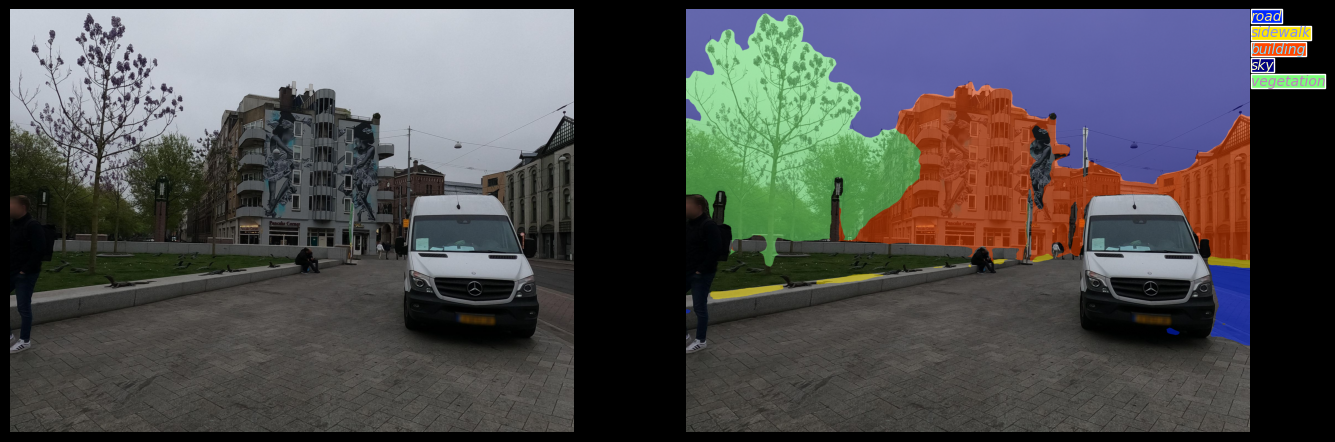

In [45]:
(fig, ax, stats) = sseg.visualise_segmentation(image_path, categories, ds=ds)

Pretty-print the statistics.

In [46]:
pp(stats)

{
    'sky': {
        'colour': {
            'median': array([191, 198, 208], dtype=uint8),
            'mode': array([196, 200, 213], dtype=uint8),
            'mean': array([188, 194, 204], dtype=uint8),
            'sd': array([13, 14, 14], dtype=uint8)
        },
        'area': 0.23154067993164062
    },
    'road': {
        'colour': {
            'median': array([62, 57, 55], dtype=uint8),
            'mode': array([51, 51, 51], dtype=uint8),
            'mean': array([61, 57, 55], dtype=uint8),
            'sd': array([15, 13, 12], dtype=uint8)
        },
        'area': 0.011378288269042969
    },
    'water': {
        'colour': {
            'median': array([0, 0, 0], dtype=uint8),
            'mode': array([0, 0, 0], dtype=uint8),
            'mean': array([0, 0, 0], dtype=uint8),
            'sd': array([0, 0, 0], dtype=uint8)
        },
        'area': 0.0
    },
    'vegetation': {
        'colour': {
            'median': array([79, 79, 80], dtype=uint8),
            'mode': array([194, 201, 211], dtype=uint8),
            'mean': array([100, 102, 101], dtype=uint8),
            'sd': array([68, 70, 79], dtype=uint8)
        },
        'area': 0.1472317377726237
    },
    'sidewalk': {
        'colour': {
            'median': array([106, 104, 101], dtype=uint8),
            'mode': array([111, 110, 106], dtype=uint8),
            'mean': array([87, 85, 82], dtype=uint8),
            'sd': array([33, 33, 33], dtype=uint8)
        },
        'area': 0.005463918050130208
    },
    'building': {
        'colour': {
            'median': array([55, 56, 53], dtype=uint8),
            'mode': array([83, 87, 89], dtype=uint8),
            'mean': array([56, 57, 57], dtype=uint8),
            'sd': array([35, 36, 37], dtype=uint8)
        },
        'area': 0.1413100560506185
    }
}